In [1]:
from velocity_plot import velocity_plot as vpl
# from velocity_plot import corr_coeff,velocity_correlation,velocity_projection,data_reshape,run_velocity_embedding
from turtle import color
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from sampling import *
import pandas as pd
from colormap import *
import random
import os

In [2]:
# load raw
raw_data_path = "/Users/wanglab/Documents/ShengyuLi/Velocity/data/raw_data/mouse_endo_blood20to25_2000_genes_moment10.csv"
load_raw_data = pd.read_csv(raw_data_path)
# combine detail
detail_result_path = '/Users/wanglab/Documents/ShengyuLi/Velocity/data/Gastrulation/velocity_result/result_detailcsv/2000_genes'
path_name_after_no='_all_geneepoch200check_n10Lr0.001C2cf0.3Downneighbors0_200_200Ratio0.125N30OAdamtraceR0.0corrcoefR0.0/detail_e200.csv'
load_cellDancer=pd.DataFrame()
for i in range(1,11):
    detail_path=os.path.join(detail_result_path,(str(i)+path_name_after_no))
    detail=pd.read_csv(detail_path)
    load_cellDancer=load_cellDancer.append(detail)
load_cellDancer_bkup=load_cellDancer.copy()

In [3]:
print(load_raw_data.columns)
print(load_cellDancer.columns)

Index(['gene_list', 'u0', 's0', 'cellID', 'clusters', 'embedding1',
       'embedding2'],
      dtype='object')
Index(['Unnamed: 0', 'gene_name', 's0', 'u0', 's1', 'u1', 'alpha', 'beta',
       'gamma', 'cost'],
      dtype='object')


In [4]:
# define cell velocity para
n_neighbors_list = [50, 100, 150, 200, 250, 300]
add_amt_gene_list = [200, 400, 600, 800, 1200, 1600, 2000]

In [5]:
# define output path
output_path = '/Users/wanglab/Documents/ShengyuLi/Velocity/data/Gastrulation/velocity_result/result_detailcsv/2000_genes/cell_velocity'


In [34]:
# debug of parallel for cell level embedding

from joblib import Parallel, delayed
import pandas as pd
import numpy as np

def data_reshape(load_cellDancer):
    '''
    load detail file
    return expression matrix and velocity (ngenes, ncells)
    '''
    psc = 1
    gene_names = load_cellDancer['gene_name'].drop_duplicates().to_list()
    # cell_number = load_cellDancer[load_cellDancer['gene_name']==gene_names[0]].shape[0]
    # load_cellDancer['index'] = np.tile(range(cell_number),len(gene_names))
    # load_cellDancer['index'] = 0
    load_cellDancer.loc[:,'index']=0
    for g in gene_names:
        load_cellDancer.loc[load_cellDancer['gene_name'] == g, 'index'] = range(
            load_cellDancer[load_cellDancer['gene_name'] == g].shape[0])
    s0_reshape = load_cellDancer.pivot(
        index='gene_name', values='s0', columns='index')
    s1_reshape = load_cellDancer.pivot(
        index='gene_name', values='s1', columns='index')
    dMatrix = s1_reshape-s0_reshape
    np_s0_reshape = np.array(s0_reshape)
    np_dMatrix = np.array(dMatrix)
    np_dMatrix2 = np.sqrt(np.abs(np_dMatrix) + psc) * \
        np.sign(np_dMatrix)  # (2159, 18140)
    return(np_s0_reshape, np_dMatrix2)



load_cellDancer_input=pd.read_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/Gastrulation/velocity_result/result_detailcsv/2000_genes/1_all_geneepoch200check_n10Lr0.001C2cf0.3Downneighbors0_200_200Ratio0.125N30OAdamtraceR0.0corrcoefR0.0/detail_e200.csv')
gene_list_full=load_cellDancer_input.gene_name.drop_duplicates()
gene_list_choice=gene_list_full[0:30]
load_cellDancer_input=load_cellDancer_input[load_cellDancer_input.gene_name.isin(gene_list_choice)]
process_gene_amt_each_job=100
gene_amt=len(set(load_cellDancer_input.gene_name))

def _s0_matrix_thread(data_index,load_cellDancer_input,process_gene_amt_each_job,gene_list_choice):
    # data_index:start index of gene in load_cellDancer_input
    
    if data_index+process_gene_amt_each_job<gene_amt:
        print('test1')
        load_cellDancer=load_cellDancer_input[load_cellDancer_input.gene_name.isin(gene_list_choice[data_index:(data_index+process_gene_amt_each_job)])]
    else:
        print('test2')
        load_cellDancer=load_cellDancer_input[load_cellDancer_input.gene_name.isin(gene_list_choice[data_index:,])]
    np_s0, np_dMatrix = data_reshape(load_cellDancer) 
    return([np_s0,np_dMatrix])
    

result = Parallel(n_jobs=10, backend="loky")(
    delayed(_s0_matrix_thread)(data_index=data_index,load_cellDancer_input=load_cellDancer_input,process_gene_amt_each_job=process_gene_amt_each_job,gene_list_choice=gene_list_choice)
    for data_index in range(0,gene_amt,process_gene_amt_each_job))

# combine result
for i,result_i in enumerate(result):
    print(i)
    np_s0=result_i[0]
    np_dMatrix=result_i[1]
    if i == 0:
        np_s0_all = np_s0
        np_dMatrix_all = np_dMatrix
    else:
        np_s0_all = np.vstack((np_s0_all, np_s0))
        np_dMatrix_all = np.vstack((np_dMatrix_all, np_dMatrix))

0


In [36]:
np_dMatrix_all.shape

(30, 12329)

In [ ]:
# Debug - NO Parallel version (slow) filter_gene_by_neighbor_sample_one_gene
def filter_gene_by_neighbor_sample_one_gene(gene,load_raw_data,step_i=None,step_j=None,cutoff_s0_zero_ratio=None,cutoff_u0_zero_ratio=None):
    print(gene)
    u_s= np.array(load_raw_data[load_raw_data['gene_list']==gene][["u0","s0"]]) # u_s
    sampling_idx=sampling_neighbors(u_s[:,0:2], step_i=step_i,step_j=step_j,percentile=15) # Sampling
    u_s_downsample = u_s[sampling_idx,0:4]
    u_s_df=pd.DataFrame({"s0":u_s_downsample[:, 1],'u0':u_s_downsample[:, 0]})
    u_s_df=u_s_df[~((u_s_df.s0==0) & (u_s_df.u0==0))]
    # print(u_s_df)
    u_s_df_zero_amt=u_s_df.agg(lambda x: x.eq(0).sum())
    sampled_gene_amt=len(u_s_df)
    u_s_df_zero_ratio=u_s_df_zero_amt/sampled_gene_amt
    # plt.figure(None,(6,6))
    # plt.scatter(u_s_df.s0,u_s_df.u0,alpha=0.1)
    # plt.show()
    # return [u_s_df_zero_ratio.s0,u_s_df_zero_ratio.u0]
    # return(u_s_df)
    if ~(u_s_df_zero_ratio.s0>cutoff_s0_zero_ratio or u_s_df_zero_ratio.u0>cutoff_u0_zero_ratio):
        return(gene)
    
def filter_gene_by_neighbor_sample(load_raw_data,gene_list=None,step_i=15,step_j=15,cutoff_s0_zero_ratio=0.2,cutoff_u0_zero_ratio=0.2):
    if gene_list is None:gene_list=load_raw_data.gene_list.drop_duplicates()
    
    gene_list_keep=[]
    for i,gene in enumerate(gene_list):
        print(i)
        filter_result=filter_gene_by_neighbor_sample_one_gene(gene,load_raw_data,step_i=step_i,step_j=step_j,cutoff_s0_zero_ratio=cutoff_s0_zero_ratio,cutoff_u0_zero_ratio=cutoff_u0_zero_ratio)
        if filter_result is not None:gene_list_keep.append(filter_result)
    return(gene_list_keep)

cutoff_s0_zero_ratio=0.2
cutoff_u0_zero_ratio=0.2
list_fin=[]
# gene_list_keep=filter_gene_by_neighbor_sample(load_raw_data)
gene_list_keep=filter_gene_by_neighbor_sample(load_raw_data,gene_list=['Smim1','Hba-x','Myo1b','Coro2b'])

print(gene_list_keep)

In [ ]:
# debug parallel filter gene_by_neighbor_sample_one_gene

def filter_gene_by_neighbor_sample_one_gene(gene,load_raw_data,step_i=None,step_j=None,cutoff_s0_zero_ratio=None,cutoff_u0_zero_ratio=None,gene_amt_each_job=None):
    # print(gene)
    u_s= np.array(load_raw_data[load_raw_data['gene_list']==gene][["u0","s0"]]) # u_s
    sampling_idx=sampling_neighbors(u_s[:,0:2], step_i=step_i,step_j=step_j,percentile=15) # Sampling
    u_s_downsample = u_s[sampling_idx,0:4]
    u_s_df=pd.DataFrame({"s0":u_s_downsample[:, 1],'u0':u_s_downsample[:, 0]})
    u_s_df=u_s_df[~((u_s_df.s0==0) & (u_s_df.u0==0))]
    # print(u_s_df)
    u_s_df_zero_amt=u_s_df.agg(lambda x: x.eq(0).sum())
    sampled_gene_amt=len(u_s_df)
    u_s_df_zero_ratio=u_s_df_zero_amt/sampled_gene_amt
    # plt.figure(None,(6,6))
    # plt.scatter(u_s_df.s0,u_s_df.u0,alpha=0.1)
    # plt.show()
    # return [u_s_df_zero_ratio.s0,u_s_df_zero_ratio.u0]
    # return(u_s_df)
    if ~(u_s_df_zero_ratio.s0>cutoff_s0_zero_ratio or u_s_df_zero_ratio.u0>cutoff_u0_zero_ratio):
        return(gene)

def filter_gene_by_neighbor_sample(start_point,load_raw_data,gene_list=None,step_i=None,step_j=None,cutoff_s0_zero_ratio=None,cutoff_u0_zero_ratio=None,gene_amt_each_job=None):
    if start_point+gene_amt_each_job<len(load_raw_data.gene_list.drop_duplicates())
        gene_list=load_raw_data.gene_list.drop_duplicates()[start_point:(start_point+gene_amt_each_job)]
    else:
        gene_list=load_raw_data.gene_list.drop_duplicates()[start_point:,]
    print(gene_list)
    gene_list_keep=[]
    for i,gene in enumerate(gene_list):
        print(i)
        filter_result=filter_gene_by_neighbor_sample_one_gene(gene,load_raw_data,step_i=step_i,step_j=step_j,cutoff_s0_zero_ratio=cutoff_s0_zero_ratio,cutoff_u0_zero_ratio=cutoff_u0_zero_ratio,gene_amt_each_job=gene_amt_each_job)
        if filter_result is not None:gene_list_keep.append(filter_result)
    return(gene_list_keep)

# cutoff_s0_zero_ratio=0.2
# cutoff_u0_zero_ratio=0.2
# list_fin=[]
# gene_list_keep=filter_gene_by_neighbor_sample(load_raw_data)
# gene_list_keep=filter_gene_by_neighbor_sample(load_raw_data,gene_list=['Smim1','Hba-x','Myo1b','Coro2b'])

print(gene_list_keep)


def parallel_get_gene(load_raw_data,gene_list=None,step_i=15,step_j=15,cutoff_s0_zero_ratio=0.2,cutoff_u0_zero_ratio=0.2,gene_amt_each_job=100):
    if gene_list is None:
        gene_list=load_raw_data.gene_list.drop_duplicates().reset_index(drop=True)
    else:
        load_raw_data=load_raw_data[load_raw_data.gene_list.isin(gene_list)]
    print(gene_list)
    result = Parallel(n_jobs=-1, backend="multiprocessing",verbose=10)(
        delayed(filter_gene_by_neighbor_sample)(start_point,load_raw_data,gene_list=gene_list,step_i=step_i,step_j=step_j,cutoff_s0_zero_ratio=cutoff_s0_zero_ratio,cutoff_u0_zero_ratio=cutoff_u0_zero_ratio,gene_amt_each_job=gene_amt_each_job)
        for start_point in range(0,len(gene_list),gene_amt_each_job))
    return(result)


gene_list_keep=parallel_get_gene(load_raw_data,gene_amt_each_job=100)


print(gene_list_keep)

# combine
gene_list_keep_fin=[]
for segment_list in gene_list_keep:
    gene_list_keep_fin=gene_list_keep_fin+segment_list
len(gene_list_keep_fin)
gene_list_keep_fin_pd=pd.DataFrame({'gene_list':gene_list_keep_fin})
gene_list_keep_fin_pd.to_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/Gastrulation/velocity_result/result_detailcsv/2000_genes/cell_velocity/gene_list_keep_fin_0.2cutoff.csv',index=False)

In [191]:
# Debug - filter gene by raw data s0 ratio and u0 ratio
# Seems not working as expected, so change to filter after downsample by neighbor
u0_ratio_cutoff=0.2
s0_ratio_cutoff=0.2
load_cellDancer=load_cellDancer_full.copy()
def filter_raw(load_cellDancer,u0_ratio_cutoff,s0_ratio_cutoff):
    gene_list=load_cellDancer.gene_name.drop_duplicates()
    one_gene_raw=load_cellDancer[load_cellDancer.gene_name==load_cellDancer.reset_index().gene_name[0]]

    filter_table = load_cellDancer[['gene_name','u0','s0']].groupby('gene_name',sort=False).agg(lambda x: x.eq(0).sum())
    cell_amt=len(one_gene_raw)
    filter_table['u0_ratio']=(filter_table.u0)/cell_amt
    filter_table['s0_ratio']=(filter_table.s0)/cell_amt
    # plt.figure()
    # filter_table.u0_ratio.hist(bins=100)
    # plt.figure()
    # filter_table.s0_ratio.hist(bins=100)
    throw_by_u0_s0=filter_table[(filter_table.u0_ratio>u0_ratio_cutoff) | (filter_table.s0_ratio>s0_ratio_cutoff)].index
    print('filter '+str(len(throw_by_u0_s0))+' genes')
    filter_table[filter_table.index.isin(['Smim1','Hba-x','Myo1b','Coro2b'])]


    load_cellDancer_filtered=load_cellDancer[~load_cellDancer.gene_name.isin(throw_by_u0_s0)]
    return(load_cellDancer_filtered)
load_cellDancer=filter_raw(load_cellDancer,u0_ratio_cutoff,s0_ratio_cutoff)


filter 873 genes


,u0,s0,u0_ratio,s0_ratio
gene_name,,,,
Myo1b,5011,3908,0.406440,0.316976
Hba-x,4248,119,0.344553,0.009652
Smim1,493,0,0.039987,0.000000
Coro2b,6627,3908,0.537513,0.316976


In [6]:
# cell plot raw data & detail filter

# four samples
four_samples=['Smim1','Hba-x','Myo1b','Coro2b']
# four_samples=['Hba-x','Myo1b']
load_raw_data_four_samples=load_raw_data[load_raw_data.gene_list.isin(four_samples)].reset_index()
load_cellDancer_four_samples=load_cellDancer[load_cellDancer.gene_name.isin(four_samples)].reset_index()

# 0.2 cutoff
# load_raw_data_point2=load_raw_data[load_raw_data.gene_list.isin(gene_list_keep_fin)].reset_index()
# load_cellDancer_point2=load_cellDancer[load_cellDancer.gene_name.isin(gene_list_keep_fin)]

# filter out out of bounds points
# load_cellDancer_new=pd.concat([load_cellDancer,load_raw_data[['embedding1','embedding2']]],axis=1)
# id_filter_out=((load_raw_data.embedding1<6) | (load_raw_data.embedding1>13) | (load_raw_data.embedding1<3))
# load_raw_data_cell_filter=load_raw_data[~id_filter_out].reset_index()
# load_cellDancer_cell_filter=load_cellDancer[~id_filter_out].reset_index()

In [ ]:
gene_list_keep_fin_pd=pd.read_csv('/Users/wanglab/Documents/ShengyuLi/Velocity/data/Gastrulation/velocity_result/result_detailcsv/2000_genes/cell_velocity/cutoff0.2/gene_list_keep_fin_0.2cutoff_keep950geneInsteadOf1127.csv')

In [15]:
load_raw_data_cf02_geneAmt952=load_raw_data[load_raw_data.gene_list.isin(gene_list_keep_fin_pd.gene_list)].reset_index()
load_cellDancer_cf02_geneAmt952=load_cellDancer[load_cellDancer.gene_name.isin(gene_list_keep_fin_pd.gene_list)].reset_index()



------n_neighbors20
------add_amt_gene2000
neighbors
using gene mode
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
(2000, 12329)
(2000, 12329)


/Users/wanglab/Documents/ShengyuLi/Velocity/bin/cellDancer-development_20220128/src/get_embedding.py:50: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt(np.dot(ematrix_ss[:, None], vmatrix_ss[None]))


3.4675463757395963
0.4525056844806137
0.13049737060375963


/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

------n_neighbors30
------add_amt_gene2000


/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

neighbors
using gene mode


/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
(2000, 12329)
(2000, 12329)


/Users/wanglab/Documents/ShengyuLi/Velocity/bin/cellDancer-development_20220128/src/get_embedding.py:50: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt(np.dot(ematrix_ss[:, None], vmatrix_ss[None]))


3.4275004572727727
0.4525056844806137
0.1320220639272118


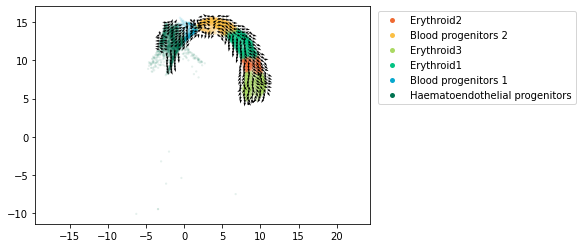

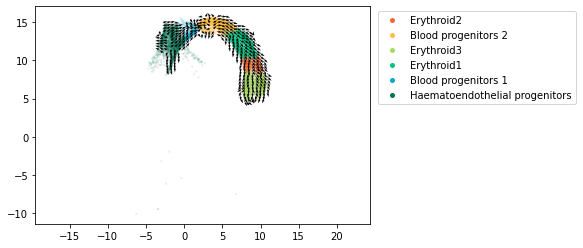

In [20]:
# cell plot - main function
colors = {'Erythroid2':grove2[6],
'Blood progenitors 2':grove2[5],
'Erythroid3':grove2[4],
'Erythroid1':grove2[3],
'Blood progenitors 1':grove2[2],
'Haematoendothelial progenitors':grove2[1],
'Blood progenitors 1':grove2[0]}

# n_neighbors_list=[10,20,30,40,50]
n_neighbors_list=[20,30]
add_amt_gene_list=[2000]
for n_neighbors in n_neighbors_list:
    print('------n_neighbors'+str(n_neighbors))
    for add_amt_gene in add_amt_gene_list:
        print('------add_amt_gene'+str(add_amt_gene))
        
        save_path = '/Users/wanglab/Documents/ShengyuLi/Velocity/data/Gastrulation/velocity_result/result_detailcsv/2000_genes/cell_velocity'
        # velocity_cell_draft(load_raw_data,load_cellDancer,n_neighbors,add_amt_gene, save_path=save_path, save_csv=True,gene_list=None, custom_xlim=None,colors=colors,step=(100,100))
        # vpl.velocity_cell_map(load_raw_data,load_cellDancer,n_neighbors,add_amt_gene, save_path=save_path, save_csv=True, gene_list=None, custom_xlim=None,colors=colors,step=(100,100),mode='gene')
        vpl.velocity_cell_map_curve(load_raw_data,load_cellDancer,n_neighbors,add_amt_gene, save_path=save_path, save_csv=True, gene_list=None, custom_xlim=None,colors=colors,step=(100,100),mode='gene')

------n_neighbors20
------add_amt_gene952
neighbors
using gene mode
0
1
2
3
4
5
6
7
8
9
(952, 12329)
(952, 12329)


/Users/wanglab/Documents/ShengyuLi/Velocity/bin/cellDancer-development_20220128/src/get_embedding.py:50: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt(np.dot(ematrix_ss[:, None], vmatrix_ss[None]))


3.493025278047513
0.4525056844806137
0.12954549379429328
------n_neighbors30
------add_amt_gene952


/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


neighbors
using gene mode


/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

0
1
2
3
4
5
6
7
8
9
(952, 12329)
(952, 12329)


/Users/wanglab/Documents/ShengyuLi/Velocity/bin/cellDancer-development_20220128/src/get_embedding.py:50: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt(np.dot(ematrix_ss[:, None], vmatrix_ss[None]))


3.379718243310571
0.4525056844806137
0.1338885823918168


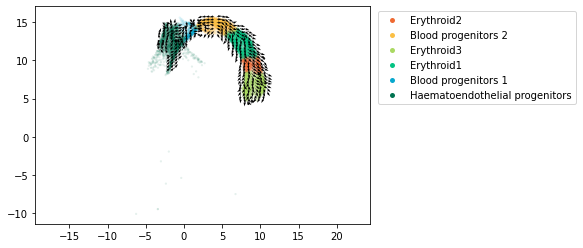

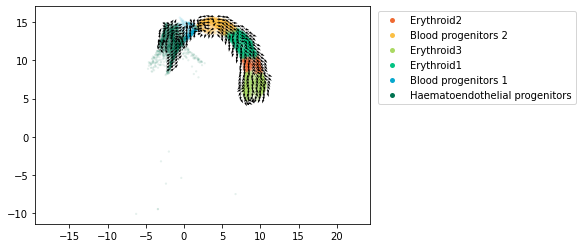

/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/wanglab/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [21]:

# n_neighbors_list=[10,20,30,40,50]
n_neighbors_list=[20,30]
add_amt_gene_list=[952]
for n_neighbors in n_neighbors_list:
    print('------n_neighbors'+str(n_neighbors))
    for add_amt_gene in add_amt_gene_list:
        print('------add_amt_gene'+str(add_amt_gene))
        
        save_path = '/Users/wanglab/Documents/ShengyuLi/Velocity/data/Gastrulation/velocity_result/result_detailcsv/2000_genes/cell_velocity'
        # velocity_cell_draft(load_raw_data,load_cellDancer,n_neighbors,add_amt_gene, save_path=save_path, save_csv=True,gene_list=None, custom_xlim=None,colors=colors,step=(100,100))
        # vpl.velocity_cell_map(load_raw_data,load_cellDancer,n_neighbors,add_amt_gene, save_path=save_path, save_csv=True, gene_list=None, custom_xlim=None,colors=colors,step=(100,100),mode='gene')
        vpl.velocity_cell_map_curve(load_raw_data_cf02_geneAmt952,load_cellDancer_cf02_geneAmt952,n_neighbors,add_amt_gene, save_path=save_path, save_csv=True, gene_list=None, custom_xlim=None,colors=colors,step=(100,100),mode='gene')

In [24]:
data_df = load_raw_data[['gene_list', 'u0', 's0', 'cellID',
                                'embedding1', 'embedding2']]

In [39]:
# data_df.cellID.drop_duplicates()
data_df
gene = data_df['gene_list'].drop_duplicates().iloc[0]
cellID = data_df.loc[data_df['gene_list']==gene]['cellID']
data_df_pivot=data_df.pivot(index='cellID', columns='gene_list', values='s0').reindex(cellID)
data_df_pivot.to_numpy()

gene_list,0610010F05Rik,1110038B12Rik,1500009L16Rik,1700017B05Rik,1700027J19Rik,1700037H04Rik,1810022K09Rik,1810026B05Rik,1810032O08Rik,2410003L11Rik,...,Zfpm1,Zmynd19,Zmynd8,Znrf1,Znrf3,Zrsr2,Zscan21,Zscan26,Zswim6,Zswim7
cellID,,,,,,,,,,,,,,,,,,,,,
cell_363,0.312842,1.355268,0.622760,0.114831,0.721873,1.257351,1.524681,0.129449,0.456592,0.099245,...,0.787641,1.196947,0.361013,0.207883,0.094735,0.936427,0.185909,0.020677,0.130681,0.292944
cell_382,0.246910,1.420308,0.870611,0.060433,1.004247,0.976350,1.718881,0.155994,0.506875,0.032253,...,0.697805,1.023084,0.403128,0.107241,0.019724,1.057224,0.177920,0.000000,0.116689,0.202664
cell_385,0.168916,1.079459,0.638548,0.060933,1.007857,1.050768,1.319454,0.174050,0.357582,0.042017,...,0.651772,0.901413,0.249280,0.165020,0.026013,0.837642,0.166337,0.011003,0.169939,0.267874
cell_393,0.098369,1.904841,0.443685,0.137706,0.494196,1.691759,1.854104,0.246186,0.332946,0.085826,...,0.912006,1.571504,0.309163,0.193089,0.065988,0.681012,0.188783,0.025781,0.080167,0.148841
cell_398,0.116754,1.416954,0.486867,0.124115,0.599960,1.560848,1.564530,0.286185,0.367296,0.097985,...,0.769533,0.896901,0.186434,0.181956,0.072231,0.695128,0.151390,0.000000,0.104746,0.318376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_139318,0.082322,0.551254,0.138677,0.121784,0.032495,1.348866,1.103817,0.072928,0.129302,0.019651,...,0.643115,0.571773,0.115534,0.169780,0.028380,0.255452,0.238511,0.004707,0.000000,0.239490
cell_139321,0.039810,0.602661,0.042346,0.040416,0.024868,1.424142,1.119094,0.127680,0.165284,0.026267,...,0.575885,0.583591,0.060545,0.139103,0.005195,0.204272,0.171801,0.004991,0.000000,0.320673
cell_139326,0.029527,0.742363,0.102660,0.089212,0.010656,1.393553,1.461425,0.083811,0.181590,0.017961,...,0.512188,0.493041,0.107999,0.098086,0.021487,0.230350,0.150204,0.000000,0.020103,0.211783


In [42]:
data_df_pivot.iloc[[1,2]]

gene_list,0610010F05Rik,1110038B12Rik,1500009L16Rik,1700017B05Rik,1700027J19Rik,1700037H04Rik,1810022K09Rik,1810026B05Rik,1810032O08Rik,2410003L11Rik,...,Zfpm1,Zmynd19,Zmynd8,Znrf1,Znrf3,Zrsr2,Zscan21,Zscan26,Zswim6,Zswim7
cellID,,,,,,,,,,,,,,,,,,,,,
cell_382,0.246910,1.420308,0.870611,0.060433,1.004247,0.976350,1.718881,0.155994,0.506875,0.032253,...,0.697805,1.023084,0.403128,0.107241,0.019724,1.057224,0.177920,0.000000,0.116689,0.202664
cell_385,0.168916,1.079459,0.638548,0.060933,1.007857,1.050768,1.319454,0.174050,0.357582,0.042017,...,0.651772,0.901413,0.249280,0.165020,0.026013,0.837642,0.166337,0.011003,0.169939,0.267874


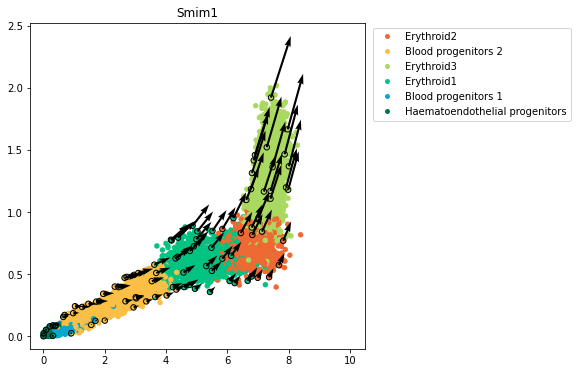

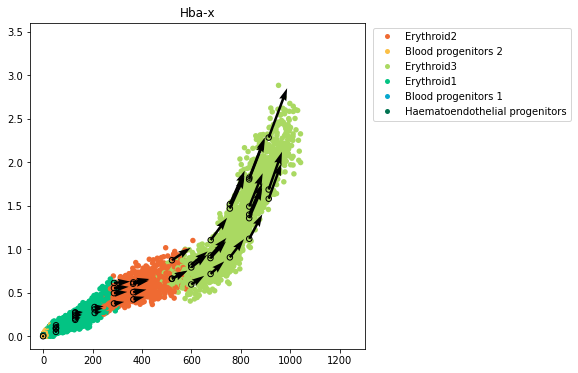

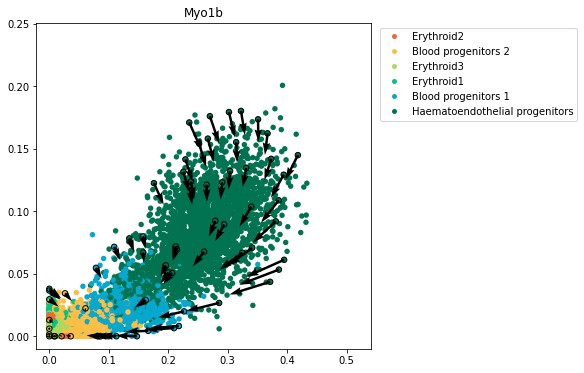

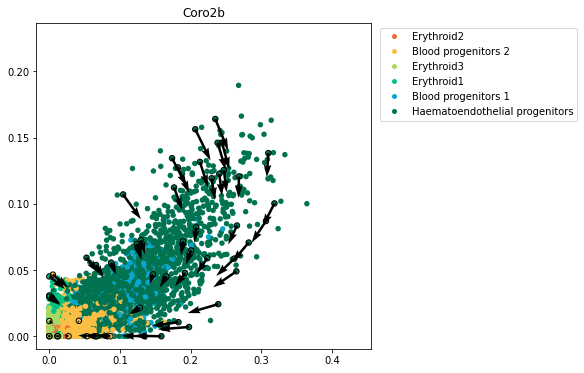

In [21]:
# gene velocity plot
colors = {'Erythroid2':grove2[6],
'Blood progenitors 2':grove2[5],
'Erythroid3':grove2[4],
'Erythroid1':grove2[3],
'Blood progenitors 1':grove2[2],
'Haematoendothelial progenitors':grove2[1],
'Blood progenitors 1':grove2[0]}

# vpl.velocity_gene('Smim1',load_cellDancer)
# vpl.velocity_gene('Hba-x',load_cellDancer)
# vpl.velocity_gene('Myo1b',load_cellDancer)
# vpl.velocity_gene('Coro2b',load_cellDancer)
# colors = {'Erythroid2':'purple',
# 'Blood progenitors 2':'orange',
# 'Erythroid3':'brown',
# 'Erythroid1':'red',
# 'Blood progenitors 1':'blue',
# 'Haematoendothelial progenitors':'pink',
# 'Blood progenitors 1':'blue'}

one_gene_raw=load_raw_data[load_raw_data.gene_list==load_raw_data.gene_list.iloc[0]]
cluster_info=one_gene_raw['clusters']

# for gene in gene_list_keep_fin[20:30]:
for gene in four_samples:
    vpl.velocity_gene(gene,load_cellDancer,colors=colors,mode='cluster',cluster_annot=True,cluster_info=cluster_info,point_size=30,alpha_inside=1)

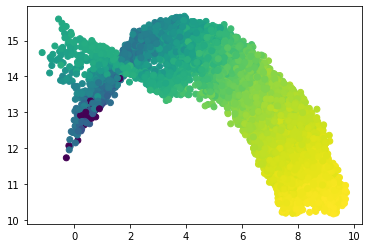

In [22]:
# Hba-x s0 in three clusters
load_raw_data_hba=load_raw_data[load_raw_data.gene_list.isin(['Hba-x'])].reset_index()
load_cellDancer_hba=load_cellDancer[load_cellDancer.gene_name.isin(['Hba-x'])].reset_index()
cell_keep=['Blood progenitors 2','Blood progenitors 1','Erythroid1']
load_raw_data_hba=load_raw_data_hba[load_raw_data_hba.clusters.isin(cell_keep)]
plt.scatter(load_raw_data_hba.embedding1, load_raw_data_hba.embedding2,c=np.log((load_raw_data_hba.s0+0.0001).to_numpy()))
# plt.savefig('/Users/wanglab/Documents/ShengyuLi/Velocity/data/Gastrulation/velocity_result/result_detailcsv/2000_genes/cell_level_s0/Hba-x_s0_21BP1_22BP2_23ERY1.pdf')

In [ ]:
def velocity_cell_draft(load_raw_data,load_cellDancer, n_neighbors=200,add_amt_gene=2000,step=(60,60),save_path=None, save_csv=None,gene_list=None, custom_xlim=None,colors=None):
    from get_embedding import get_embedding

    embedding, sampling_ixs, velocity_embedding=get_embedding(load_raw_data,load_cellDancer,gene_list=gene_list,n_neighbors=n_neighbors,step=step)

    
    
    # plt.quiver(embedding[sampling_ixs, 0],embedding[sampling_ixs, 1],velocity_embedding[:, 0],velocity_embedding[:, 1])
    if save_path is not None:
        plt.savefig(os.path.join(save_path,('velocity_embedding_tune_n' + \
        str(n_neighbors)+'_gAmt'+str(add_amt_gene) + \
        '_draft.pdf')))
    if save_csv is not None:
        cell_velocity_df=pd.DataFrame({'embedding1':embedding[sampling_ixs, 0],
                     'embedding2':embedding[sampling_ixs, 1],
                     ('embedding1_n'+str(n_neighbors)+'_gAmt'+str(add_amt_gene)):velocity_embedding[:, 0],
                     ('embedding2_n'+str(n_neighbors)+'_gAmt'+str(add_amt_gene)):velocity_embedding[:, 1]})
        cell_velocity_df.to_csv(os.path.join(save_path,('velocity_embedding_tune_n' + \
        str(n_neighbors)+'_gAmt'+str(add_amt_gene) + \
        '_draft.csv')))